In [97]:
import os
import math
import string
import pickle
import enchant
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter, defaultdict

from scipy.spatial import KDTree

In [18]:
hidden_dim = 128

model_name = "word2vec"
dataset = "menu"

if dataset == "retail":
    menu_fname = "retail_price.csv"
    vocab_fname = "retail_vocab_v2.p"
    encoding = "ISO-8859-1"
    item_column_name = "Description"
    factor_column_name = "Country"
    price_column_name = "UnitPrice"

elif dataset == "menu":
    menu_fname = "menu_price_1125.csv"
    vocab_fname = "menu_vocab_v2.p"
    encoding = "utf-8"
    item_column_name = "item"
    factor_column_name = "city"
    price_column_name = "price"

elif dataset == "shoe":
    menu_fname = "shoe_price.csv"
    vocab_fname = "shoe_vocab_v2.p"
    encoding = "ISO-8859-1"
    item_column_name = "name"
    factor_column_name = "brand"
    price_column_name = "prices.amountMax"

elif dataset == "reward":
    menu_fname = "reward_price.csv"
    vocab_fname = "reward_vocab_v2.p"
    encoding = "utf-8"
    item_column_name = "description"
    factor_column_name = "category"
    price_column_name = "price"

In [4]:
all_stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
english_dict = enchant.Dict("en_US")


def remove_digits(s):
    return ''.join([i for i in s if not i.isdigit()])


def lemmatize(s):
    return wordnet_lemmatizer.lemmatize(s.lower().encode("ascii", "ignore").decode("utf-8"))


def clean(s):
    tmp_words = s.lower().split(" ")
    tmp_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in tmp_words]
    tmp_words = [remove_digits(word) for word in tmp_words]
    tmp_words = [lemmatize(word) for word in tmp_words]
    tmp_words = [word for word in tmp_words if len(word) > 1]
    tmp_words = [word for word in tmp_words if english_dict.check(word)]
    tmp_words = [word.strip() for word in tmp_words]

    return tmp_words

def read_menu(data_path, menu_fname, na_values="None", encoding="utf-8"):
    """
    parameters
    - encoding: the file encoding of menu_fname. Options: utf-8, ISO-8859-1
    """
    return  pd.read_csv(os.path.join(data_path, menu_fname), na_values=na_values, encoding=encoding)

In [5]:
menu_frame = read_menu("../data/", menu_fname, encoding=encoding)

In [19]:
X_dict = pickle.load(open("../trained_parameters/"+ model_name + "_" + dataset + "_X.p", "rb"))

In [7]:
all_words = [word for word in X_dict.keys()]

## Price Prediction

In [8]:
y = []

X_raw = []

for index, df in menu_frame.iterrows():
    
    try:
        words = clean(df[item_column_name])
        price = df[price_column_name]

        if not math.isnan(price) and all([word in all_words for word in words]):
            X_raw.append(words)
            y.append(price)
    except AttributeError:
        pass

In [20]:
X = []

for words in X_raw:
    tmp = np.zeros(hidden_dim)
    for word in words:
        tmp += X_dict[word]
    X.append(tmp)
    
X = np.asarray(X)
y = np.asarray(y)    
y = y.reshape(-1, 1)

target_scaler = MinMaxScaler()
target_scaler.fit(y)
y = target_scaler.transform(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr_model = LinearRegression() 
# wrapped_model = TransformedTargetRegressor(regressor=lr_model, transformer=MinMaxScaler())
# lr_model = SVR(C=1.0, epsilon=0.2)
reg = lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print (mean_squared_error(y_test, y_pred))

3.64088411746103e-05


In [38]:
df = pd.read_csv("../../word-worth-paper-materials/experiments/price_prediction.csv")

In [39]:
df.pivot(index="dataset", columns="model", values="MSE")

model,joint_wwm,mwcp,mwp,word2vec,wp
dataset,,,,,
menu,35.502011,36.349099,36.175867,36.408841,36.305019
retail,8.168064,8.168353,8.168784,8.168962,8.170853
reward,5528.452074,5844.858046,5849.751507,5944.601551,5710.338836
shoe,1676.570960,1661.384435,1614.707098,1648.532502,1662.954948


## Word Prediction

In [70]:
# y = []

questions = {}

for index, df in menu_frame.iterrows():
    
    try:
        words = clean(df[item_column_name])
        price = df[price_column_name]

        if not math.isnan(price) and all([word in all_words for word in words]) and len(words) > 1:
            if " ".join(words[:-1]) not in questions:
                questions[" ".join(words[:-1])] = [words[-1]]
            else:
                questions[" ".join(words[:-1])].append(words[-1])

    except AttributeError:
        pass

In [73]:
for query in questions:
    questions[query] = list(set(questions[query]))

In [76]:
X = []

for query in questions:
    tmp = np.zeros(hidden_dim)
    words = query.split(" ")
    for word in words:
        tmp += X_dict[word]
    X.append(tmp)
    
X = np.asarray(X)

In [51]:
embedding = []

for word in X_dict:
    x = X_dict[word]
    embedding.append(x)

embedding = np.asarray(embedding)

tree = KDTree(embedding)

In [81]:
def precision(y_pred, y_true, k):
    y_pred_tmp = y_pred[:k+1]
    overlap = set(y_pred_tmp).intersection(set(y_true))
    return float(len(overlap)) / k

def recall(y_pred, y_true, k):
    y_pred_tmp = y_pred[:k+1]
    overlap = set(y_pred_tmp).intersection(set(y_true))
    return float(len(overlap)) / len(y_true)

In [82]:
precisions_sum = defaultdict(float)
recalls_sum = defaultdict(float)
queries = [q for q in questions.keys()]

for i in range(X.shape[0]):
    
#     if i % 1000 == 0: print (i)

    query = queries[i]
    query_x = X[i]

    k = 1000 # maximum number of words retrived 
    nearest_indices = tree.query(query_x, k+1)[1]
    nearest_words = [all_words[j] for j in nearest_indices]

    for l in range(100, k+1, 100):
        
        precisions_sum[l] += precision(nearest_words, questions[query], l)
        recalls_sum[l]    += recall(nearest_words, questions[query], l)

for l in range(100, k+1, 100):
    precisions_sum[l] /= X.shape[0]
    recalls_sum[l] /= X.shape[0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000


In [83]:
for l in range(100, k+1, 100):
    print ("precision", l, precisions_sum[l])
    print ("recall", l, recalls_sum[l])

precision 100 0.00142156995478048
recall 100 0.07773407903238151
precision 200 0.0012421813652488491
recall 200 0.1333342153836244
precision 300 0.0011503434332492154
recall 300 0.18443531419592185
precision 400 0.0011021905716064589
recall 400 0.2335783952605097
precision 500 0.0010616013647072352
recall 500 0.2799868387755596
precision 600 0.00103548960674368
recall 600 0.326722703063145
precision 700 0.0010203971112151382
recall 700 0.3737927314286673
precision 800 0.0010034591535562738
recall 800 0.41770922918948145
precision 900 0.0009903754448984759
recall 900 0.46251955188102467
precision 1000 0.0009791503073299768
recall 1000 0.5068541727418114


In [91]:
df = pd.read_csv("../../word-worth-paper-materials/experiments/word_prediction.csv")

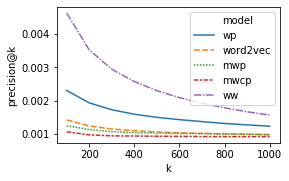

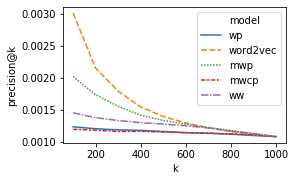

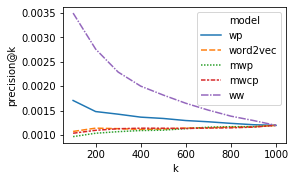

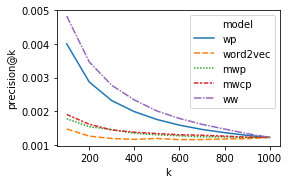

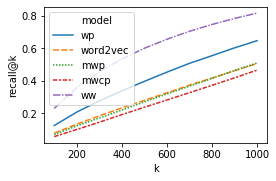

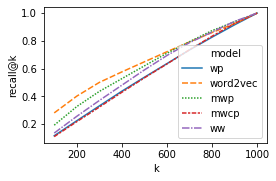

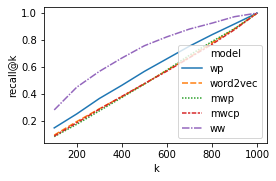

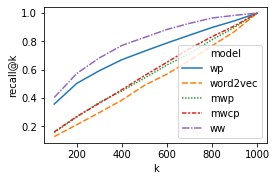

In [103]:
metrics = ["precision", "recall"]
datasets = ["menu", "shoe", "retail", "reward"]

for metric in metrics:
    for dataset in datasets:

        plt.figure(figsize=(4,2.5))
        ax = sns.lineplot(x="k", y="value", hue="model", style="model", 
                          data=df.loc[(df['metric'] == metric) & (df['dataset'] == dataset)])
        ax.set(ylabel = metric + "@k")
        plt.savefig(dataset + "_" + metric + ".pdf", bbox_inches='tight')

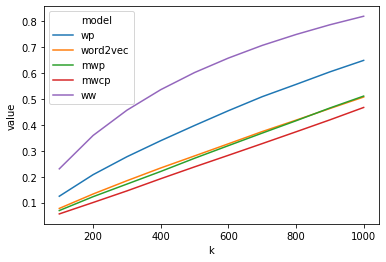

In [93]:
ax = sns.lineplot(x="k", y="value", hue="model",
                  data=df.loc[(df['metric'] == 'recall') & (df['dataset'] == 'menu')])